In [1]:
### Preprocessing requirements
import pandas as pd
# 1. Copy all .h5 and .mzML files from the job folders to a single output directory for easier access.
# 2. Run the deconvolution to make <filename>_deconvoluted.parquet files.
import os
import numpy as np
from scipy.stats import ttest_ind
# import ztest
from statsmodels.stats.weightstats import ztest
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches


In [2]:
PYTHONPATH = "/global/homes/b/bpb/repos/envnet"
if PYTHONPATH not in sys.path:
    sys.path.insert(0, PYTHONPATH)

from envnet.annotation.core import AnnotationEngine
annotation_engine = AnnotationEngine()
ref_dir = '/global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/'
node_data = annotation_engine.load_envnet_reference(
    graphml_file=os.path.join(ref_dir, "network_with_sirius.graphml"),
    mgf_base_name=os.path.join(ref_dir, "envnet")
)   
cols = ['original_index','precursor_mz','inchi_key', 'compound_name', 'smiles','NPC#pathway', 'NPC#superclass', 'NPC#class','predicted_formula']
node_data = node_data['nodes'][cols]

Loading ENVnet reference data...
  GraphML file: /global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/network_with_sirius.graphml
  Deconvoluted MGF: /global/u2/b/bpb/repos/envnet/data//global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/envnet_deconvoluted_spectra.mgf
  Original MGF: /global/u2/b/bpb/repos/envnet/data//global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/envnet_original_spectra.mgf
Loaded 22128 ENVnet nodes


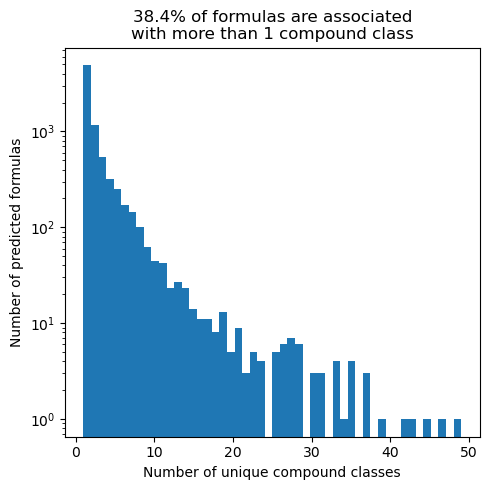

In [3]:
temp = node_data.groupby('predicted_formula')['NPC#class'].value_counts().unstack(fill_value=0)
g = temp.sum(axis=1).sort_values(ascending=False)
fig,ax = plt.subplots(1,1,figsize=(5,5))
# sns.barplot(x=g.index[:60],y=g.values[:60],ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.set_ylabel('Number of unique compound classes')
# ax.set_xlabel('Predicted formula')
ax.hist(g.values,bins=50)
my_str = f"{(g>1).sum()/len(g):.1%} of formulas are associated\nwith more than 1 compound class"
ax.set_title(my_str)
ax.set_yscale('log')
ax.set_xlabel('Number of unique compound classes')
ax.set_ylabel('Number of predicted formulas')
plt.tight_layout()

In [ ]:
node_data.head()

In [ ]:

job_folders = ['egsb/20250415_EB_MdR_109570-002_LigDiv6_20250122_QE119_C18-EP_USDAY92790',
               'egsb/20231018_EB_MdR_109570-002_WAVEstab_20231017_EXP120A_C18-EP_USDAY72349_vols',
               'egsb/20240125_EB_MdR_101544-059_WAVESTAB3_20231222_EXP120A_C18-EP_USDAY72349',
               'jgi/20220707_JGI_SB_503799_Permafrost_pilot_QE-HF_C18_USDAY63663',
               'jgi/20231004_JGI_SB_503799_Pfrost_final_QEHF_C18_USDAY81384']

data = []
output_dir = '/global/cfs/cdirs/metatlas/projects/envnet_build_files/analysis_for_manuscript'
h5_files = []
for job_folder in job_folders:
    full_dir = os.path.join('/global/cfs/cdirs/metatlas/raw_data', job_folder)
    files = os.listdir(full_dir)
    files = [f for f in files if '_NEG_' in f]
    for f in files:
        if f.endswith('.h5') | f.endswith('.mzML'):
            old_location = os.path.join(full_dir, f)
            new_location = os.path.join(output_dir, f)
            if new_location.endswith('.h5'):
                h5_files.append(new_location)
            # copy to output dir
            if not os.path.exists(new_location):
                os.system(f'cp {old_location} {new_location}')
            # data.append({'job_folder': job_folder, 'h5': os.path.join(full_dir, f)})

df = pd.DataFrame(h5_files, columns=['h5'])
df['parquet'] = df['h5'].str.replace('.h5', '_deconvoluted.parquet')
df['environmental_subclass'] = 'not applicable'
df['lcmsrun_observed'] = df['h5'].apply(lambda x: os.path.basename(x).replace('.h5', ''))
df['original_file_type'] = 'h5'
output_filename = '/global/homes/b/bpb/repos/envnet/scripts/input_for_ms1-ms2_annotation-experiments-for-paper.csv'
df.to_csv(output_filename, index=False)
# 3. For each subfolder run the ms1 and ms2 annotation scripts
# This is done by making a input.csv for each experiment that looks like this
# parquet,h5,environmental_subclass,lcmsrun_observed,original_file_type
# /global/cfs/cdirs/metatlas/projects/envnet_build_files/metatlas/20230223_EB_MdR_101544-059_SynDAC_20230223_QE144_C18-EP_USDAY72350_NEG_MS2_29_RS-HA-NA_1__18_deconvoluted.parquet,/global/cfs/cdirs/metatlas/projects/envnet_build_files/metatlas/20230223_EB_MdR_101544-059_SynDAC_20230223_QE144_C18-EP_USDAY72350_NEG_MS2_29_RS-HA-NA_1__18.h5,Suwannee River Humic Acid Standard III,metatlas/20230223_EB_MdR_101544-059_SynDAC_20230223_QE144_C18-EP_USDAY72350_NEG_MS2_29_RS-HA-NA_1__18,h5
# /global/cfs/cdirs/metatlas/projects/envnet_build_files/metatlas/20221219_EB_MdR_101544-059_PyrToDAC_20221219_EXP120A_C18-EP_USDAY63672_NEG_MS2_8_FAIII-1mg-NA_1__48_deconvoluted.parquet,/global/cfs/cdirs/metatlas/projects/envnet_build_files/metatlas/20221219_EB_MdR_101544-059_PyrToDAC_20221219_EXP120A_C18-EP_USDAY63672_NEG_MS2_8_FAIII-1mg-NA_1__48.h5,Suwannee River Fulvic Acid Standard III,metatlas/20221219_EB_MdR_101544-059_PyrToDAC_20221219_EXP120A_C18-EP_USDAY63672_NEG_MS2_8_FAIII-1mg-NA_1__48,h5
#
# and a ms1 annotation sbatch for each that looks like this for each experiment
# /global/homes/b/bpb/repos/envnet/scripts/run_env_sample_ms1-annotation.sbatch
# /global/homes/b/bpb/repos/envnet/scripts/run_env_sample_ms2-annotation.sbatch


In [ ]:
# This file has the stacked bar charts and volcano plots for the old incubation in the old manuscript
# /global/homes/b/bpb/repos/armory/armory/wave/explore_prefered_network_to_ignored.ipynb

# This file has the permafrost analysis
# /global/homes/b/bpb/repos/envnet_backup20250815/envnet/use/rawdata_network_integration-pfrost-20v55-Manuscript.ipynb

# This is the filter for the lignin experiment
# idx = df['lcmsrun_observed'].str.contains('LigDiv6_20250122')
# analysis codes for lignin experiment are here
# /global/homes/b/bpb/repos/armory/armory/wave/envnet_hits_to_all_metatlas_files.ipynb
# 20250415_EB_MdR_109570-002_LigDiv6_20250122_QE119_C18-EP_USDAY92790

# This is the filter for the syndac5 incubation experiment
# idx = df['lcmsrun_observed'].str.contains('SynDAC5')
# analysis codes for syndac5 experiment are here
# /global/homes/b/bpb/repos/armory/armory/wave/envnet_hits_to_all_metatlas_files.ipynb

# These are the folders and comparisons for the soil incubation experiments
# data_access_dict = {
#     'Potting Soil':{
#         'type':'foundational',
#         'foundational_t0':'NatCom-NLDM-Day0',
#         'foundational_t1':'NatCom-NLDM-Day7',
#         'experiment': '20231018_EB_MdR_109570-002_WAVEstab_20231017_EXP120A_C18-EP_USDAY72349_vols',
#         'username': 'egsb'
#     },
#     'Agricultural Soil NA': {
#         'type':'foundational',
#         'foundational_t0':'NatCom-d0-NA',
#         'foundational_t1':'NatCom-d7-NA',
#         'experiment': '20240125_EB_MdR_101544-059_WAVESTAB3_20231222_EXP120A_C18-EP_USDAY72349',
#         'username': 'egsb'
#     },
#      'Agricultural Soil Lo': {
#         'type':'foundational',
#         'foundational_t0':'NatCom-d0-Lo',
#         'foundational_t1':'NatCom-d7-Lo',
#         'experiment': '20240125_EB_MdR_101544-059_WAVESTAB3_20231222_EXP120A_C18-EP_USDAY72349',
#         'username': 'egsb'
#     },
#      'Agricultural Soil Hi': {
#         'type':'foundational',
#         'foundational_t0':'NatCom-d0-Hi',
#         'foundational_t1':'NatCom-d7-Hi',
#         'experiment': '20240125_EB_MdR_101544-059_WAVESTAB3_20231222_EXP120A_C18-EP_USDAY72349',
#         'username': 'egsb'
#     }, 
# }

In [4]:
ms1_filename = '/pscratch/sd/b/bpb/envnet_annotation_results/ms1_results_experiments_for_paper/ms1_annotations.parquet'
ms2_filename = '/pscratch/sd/b/bpb/envnet_annotation_results/ms2_results_experiments_for_paper/ms2_deconvoluted_annotations.parquet'
ms1_df = pd.read_parquet(ms1_filename)
print(ms1_df.shape)
ms2_cols = ['score_deconvoluted_match', 'matches_deconvoluted_match',
       'original_index_deconvoluted_match',  'filename',
        'mz_diff']
ms2_df = pd.read_parquet(ms2_filename, columns=ms2_cols)
# ms1_df = pd.merge(ms1_df, ms2_df, left_on=['lcmsrun_observed','original_index'], right_on=['filename','original_index_deconvoluted_match'], how='left')
# ms1_df.drop(columns=['original_index_deconvoluted_match','filename','confidence_level','h5'], inplace=True)
ms1_df['has_ms2_evidence'] = ms1_df['original_index'].isin(ms2_df['original_index_deconvoluted_match'].unique())
sample_metadata = pd.DataFrame(ms1_df['lcmsrun_observed'].unique(), columns=['lcmsrun_observed'])
sample_metadata['basename'] = sample_metadata['lcmsrun_observed'].apply(lambda x: os.path.basename(x))
sample_metadata['treatment'] = sample_metadata['basename'].apply(lambda x: x.split('_')[11])
print(ms1_df.shape)

(3602431, 10)
(3602431, 11)


In [5]:
sample_metadata = pd.DataFrame(ms1_df['lcmsrun_observed'].unique(), columns=['lcmsrun_observed'])
sample_metadata['basename'] = sample_metadata['lcmsrun_observed'].apply(lambda x: os.path.basename(x))
sample_metadata['project'] = sample_metadata['basename'].apply(lambda x: x.split('_')[4])
sample_metadata['treatment'] = sample_metadata['basename'].apply(lambda x: x.split('_')[12])

sample_metadata['timepoint'] = None
idx = sample_metadata['treatment'].str.contains('-d7', regex=False,case=False)
sample_metadata.loc[idx,'timepoint'] = 7
idx = sample_metadata['treatment'].str.contains('-day7', regex=False,case=False)
sample_metadata.loc[idx,'timepoint'] = 7
idx = sample_metadata['treatment'].str.contains('-d0', regex=False,case=False)
sample_metadata.loc[idx,'timepoint'] = 0
idx = sample_metadata['treatment'].str.contains('-day0', regex=False,case=False)
sample_metadata.loc[idx,'timepoint'] = 0

sample_metadata['priming'] = None
idx = sample_metadata['treatment'].str.endswith('-NA')
sample_metadata.loc[idx,'priming'] = 'Unprimed'
idx = sample_metadata['treatment'].str.contains('-na-', regex=False,case=False)
sample_metadata.loc[idx,'priming'] = 'Unprimed'
idx = sample_metadata['treatment'].str.contains('-natcom-salts', regex=False,case=False)
sample_metadata.loc[idx,'priming'] = 'Unprimed'
idx = sample_metadata['treatment'].str.endswith('-Lo')
sample_metadata.loc[idx,'priming'] = 'Low'
idx = sample_metadata['treatment'].str.contains('-0p05xnldm-', regex=False,case=False)
sample_metadata.loc[idx,'priming'] = 'Low'
idx = sample_metadata['treatment'].str.endswith('-Hi')
sample_metadata.loc[idx,'priming'] = 'High'
idx = sample_metadata['treatment'].str.contains('-0p5xnldm-', regex=False,case=False)
sample_metadata.loc[idx,'priming'] = 'High'

sample_metadata['soil_type'] = None
idx = sample_metadata['treatment'].str.contains('supern-wave-natcom', regex=False,case=False)
sample_metadata.loc[idx,'soil_type'] = 'Potting Soil'
idx = sample_metadata['treatment'].str.contains('omt1d2', regex=False,case=False)
sample_metadata.loc[idx,'soil_type'] = 'Agricultural Soil'
idx = sample_metadata['treatment'].str.contains('h4171', regex=False,case=False)
sample_metadata.loc[idx,'soil_type'] = 'H4171 lignin'
idx = sample_metadata['treatment'].str.contains('h4161', regex=False,case=False)
sample_metadata.loc[idx,'soil_type'] = 'H4161 lignin'

cols = ['timepoint','priming','soil_type']
idx = pd.notna(sample_metadata[cols]).all(axis=1)
sample_metadata = sample_metadata[idx].copy()
sample_metadata.drop(columns=['basename','treatment'], inplace=True)
ms1_df = pd.merge(ms1_df, sample_metadata, on='lcmsrun_observed', how='inner')
print(ms1_df.shape)

(1804531, 15)


In [6]:
def row_filter(df,project,column_name):
    df = df[~df[column_name].str.contains('exctrl|qc|txctrl',case=False)]
    if project == 'Potting Soil':
        return df[df[column_name].str.contains('6uL') & df[column_name].str.contains('NatCom') & df[column_name].str.contains('Day0|Day7')]
    if project == 'Agricultural Soil NA':
        return df[df[column_name].str.contains('NatCom') & df[column_name].str.contains('NA')]
    if project == 'Agricultural Soil Lo':
        return df[df[column_name].str.contains('NatCom') & df[column_name].str.contains('Lo')]
    if project == 'Agricultural Soil':
        return df[df[column_name].str.contains('NatCom') & df[column_name].str.contains('Hi')]
    elif project == 'soil-ppl':
        return df[df[column_name].str.contains('Run15')]
    # elif project == 'syncom-exudates':
        # return 
    elif project == 'century-exp':
        return df[df[column_name].str.contains('omt|cmt',case=False)]
    else:
        return df
    
def tost(control, treatment, margin=0.25):
    # Perform two one-sided tests.  Note that this
    # is specific for testing if treatment is not
    # the same as control.  If you control mean is
    # near zero this will not work.
    m = np.mean(control)
    lower_margin =  -1*margin*m
    upper_margin = margin*m
    _, p_value_lower = ztest(control, treatment, value=lower_margin, alternative='larger')
    _, p_value_upper = ztest(control, treatment, value=upper_margin, alternative='smaller')
    return max(p_value_lower, p_value_upper)

def do_ttest(df,control_group,treatment_group,do_split=True,min_intensity=1e6,margin=0.2):
    p = pd.pivot_table(df,index=['lcmsrun_observed','timepoint'],values='peak_area',columns='original_index')
    p.fillna(1e5,inplace=True)     
    cols = p.columns
    p.reset_index(inplace=True,drop=False)

    ttest = []
    for c in cols:
        idx1 = p['timepoint']==treatment_group
        idx2 = p['timepoint']==control_group
        treatment = p[c][idx1].values
        control = p[c][idx2].values
        mean_treatment = 1+treatment.mean()
        mean_control = 1+control.mean()
        if (mean_treatment<min_intensity) & (mean_control<min_intensity):
            continue
        fold_change = np.log2(mean_treatment/mean_control)
        t,p_value = ttest_ind(treatment, control)
        # Two One-Sided Tests (TOST) procedure using 50% margin
        p_tost = tost(control,treatment, margin=0.5)
        ttest.append({'original_index':c,'t':t,'p':p_value,'fc':fold_change,'tost':p_tost,
                      'mean_treatment':mean_treatment,'mean_control':mean_control,
                      'treatment_vals':treatment,
                      'control_vals':control})
    ttest = pd.DataFrame(ttest)
    return ttest



In [7]:
grouped_ms1_df = [g for _, g in ms1_df.groupby(['project','priming','soil_type'])]
out = []
for g_df in grouped_ms1_df:
    project = g_df['project'].values[0]
    priming = g_df['priming'].values[0]
    soil_type = g_df['soil_type'].values[0]
    print(f'Processing {project} {priming} {soil_type}')
    ttest = do_ttest(g_df,0,7,min_intensity=1e7)
    ttest['project'] = project
    ttest['priming'] = priming
    ttest['soil_type'] = soil_type
    idx_prefered = (ttest['fc']<-0.5) & (ttest['p']<0.05)
    idx_produced = (ttest['fc']>0.5) & (ttest['p']<0.05)
    idx_ignored = ttest['tost']<0.05
    ttest['classification'] = None
    ttest.loc[idx_prefered,'classification'] = 'prefered'
    ttest.loc[idx_produced,'classification'] = 'produced'
    ttest.loc[idx_ignored,'classification'] = 'ignored'
    out.append(ttest)
final_df = pd.concat(out, ignore_index=True)
print(final_df.shape)

Processing LigDiv6 High H4161 lignin
Processing LigDiv6 High H4171 lignin
Processing LigDiv6 Low H4161 lignin


/tmp/ipykernel_1429136/340155242.py:49: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p_value = ttest_ind(treatment, control)


Processing LigDiv6 Low H4171 lignin
Processing LigDiv6 Unprimed H4161 lignin


/tmp/ipykernel_1429136/340155242.py:49: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p_value = ttest_ind(treatment, control)


Processing LigDiv6 Unprimed H4171 lignin
Processing WAVESTAB3 High Agricultural Soil


/tmp/ipykernel_1429136/340155242.py:49: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p_value = ttest_ind(treatment, control)


Processing WAVESTAB3 Low Agricultural Soil


/tmp/ipykernel_1429136/340155242.py:49: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p_value = ttest_ind(treatment, control)


Processing WAVESTAB3 Unprimed Agricultural Soil


/tmp/ipykernel_1429136/340155242.py:49: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p_value = ttest_ind(treatment, control)


Processing WAVEstab Unprimed Potting Soil
(99105, 13)


In [8]:
temp = final_df[final_df['classification'].notna()]
idx1 = temp['soil_type'] == 'Agricultural Soil'
idx2 = temp['classification'] == 'prefered'
idx3 = temp['classification'] == 'produced'
temp = temp[idx1].copy()# & (idx2 | idx3)].copy()
temp = pd.merge(temp, node_data, on='original_index', how='left')
temp = temp.groupby('predicted_formula')['classification'].value_counts().unstack(fill_value=0)
print("There are {} formulas that are prefered, produced or ignored".format(len(temp)))
idx1 = (temp>0).sum(axis=1)>1
print('There are {} formulas that are prefered and produced or ignored'.format(temp[idx1].shape[0]))
temp = temp[(temp['prefered']>1) & (temp['produced']>1)].copy()
temp

There are 5722 formulas that are prefered, produced or ignored
There are 1004 formulas that are prefered and produced or ignored


classification,ignored,prefered,produced
predicted_formula,,,
C14H28O3,0,8,4
C16H30O3,0,3,3
C17H16O4,9,4,2
C19H22O3,0,2,3
C20H30O5S,2,2,2
C20H32N2O2,0,2,2
C25H28O5,0,2,2
C3H3N9,3,3,3
C8H5NO6,2,2,2


In [ ]:
import pandas as pd
usecols = ['original_index', 't', 'p', 'fc', 'tost',
       'mean_treatment', 'mean_control', 'treatment_vals', 'control_vals',
       'project', 'priming', 'soil_type', 'classification',
       'summary_classification', 'node_order_index', 'deconvoluted_spectrum',
       'all_features_prediction', 'formula_based_prediction']
prediction_df = pd.read_csv('training_data_with_predictions_full.csv', usecols=usecols)

prediction_df = prediction_df[prediction_df['classification'].notna()]
idx1 = prediction_df['soil_type'] == 'Agricultural Soil'


prediction_df = pd.merge(prediction_df, node_data, on='original_index', how='left')

g = prediction_df.groupby('predicted_formula')['classification'].value_counts().unstack(fill_value=0)
print("There are {} formulas that are prefered, produced or ignored".format(len(g)))
idx1 = (g>0).sum(axis=1)>1
complex_ones = g[idx1].index.tolist()
print('There are {} formulas that are prefered and produced or ignored'.format(g[idx1].shape[0]))
# temp = temp[(temp['prefered']>1) & (temp['produced']>1)].copy()
g = prediction_df.groupby('predicted_formula')[['classification','formula_based_prediction','all_features_prediction']].agg(lambda x: tuple(x)).reset_index()
def replace_words_with_numbers(x):
    out = []
    for xx in x:
        if xx=='prefered':
            out.append(0)
        elif xx=='produced':
            out.append(0)
        elif xx=='ignored':
            out.append(1)
    return tuple(out)
    
g['classification'] = g['classification'].apply(replace_words_with_numbers)
g = g[g['predicted_formula'].isin(complex_ones)].copy()
# g = g[['predicted_formula','classification','formula_based_prediction','all_features_prediction']]
# idx = g['formula_based_prediction'] != g['all_features_prediction']
g['disagreement'] = g['classification'].apply(lambda x: len(set(x))>1)
idx = g['disagreement'] == True
g = g[idx].copy()

# melt and pivot classification, formula_based_prediction, all_features_prediction
# melted = g.melt(id_vars=['predicted_formula'], value_vars=['classification','formula_based_prediction','all_features_prediction'], var_name='type', value_name='values')
cols = ['classification','formula_based_prediction','all_features_prediction']
melted = g.explode(cols)
# melted =pd.pivot_table(melted,index=['predicted_formula'], columns=['type'], values='values')
# melted.reset_index(inplace=True)
correct_formula = melted['classification'] == melted['formula_based_prediction']
correct_all = melted['classification'] == melted['all_features_prediction']
incorrect_formula = melted['classification'] != melted['formula_based_prediction']
incorrect_all = melted['classification'] != melted['all_features_prediction']
print('Formula based prediction')
print('TP: {}, FP: {}, TN: {}, FN: {}'.format(correct_formula.sum(), incorrect_formula.sum(), 0, 0))
print('All features prediction')
print('TP: {}, FP: {}, TN: {}, FN: {}'.format(correct_all.sum(), incorrect_all.sum(), 0, 0))

In [ ]:
# podman-hpc run --rm -v -it /pscratch/sd/b/bpb/20230127_JGI_ER_508059_POM_final_IDX_C18_USDAY63675:/data docker.io/proteowizard/pwiz-skyline-i-agree-to-the-vendor-licenses wine msconvert /data/*.raw

/tmp/ipykernel_1429136/539267836.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=plot_df, x='fc', y=-np.log10(plot_df['p']),
/tmp/ipykernel_1429136/539267836.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=plot_df, x='fc', y=-np.log10(plot_df['p']),


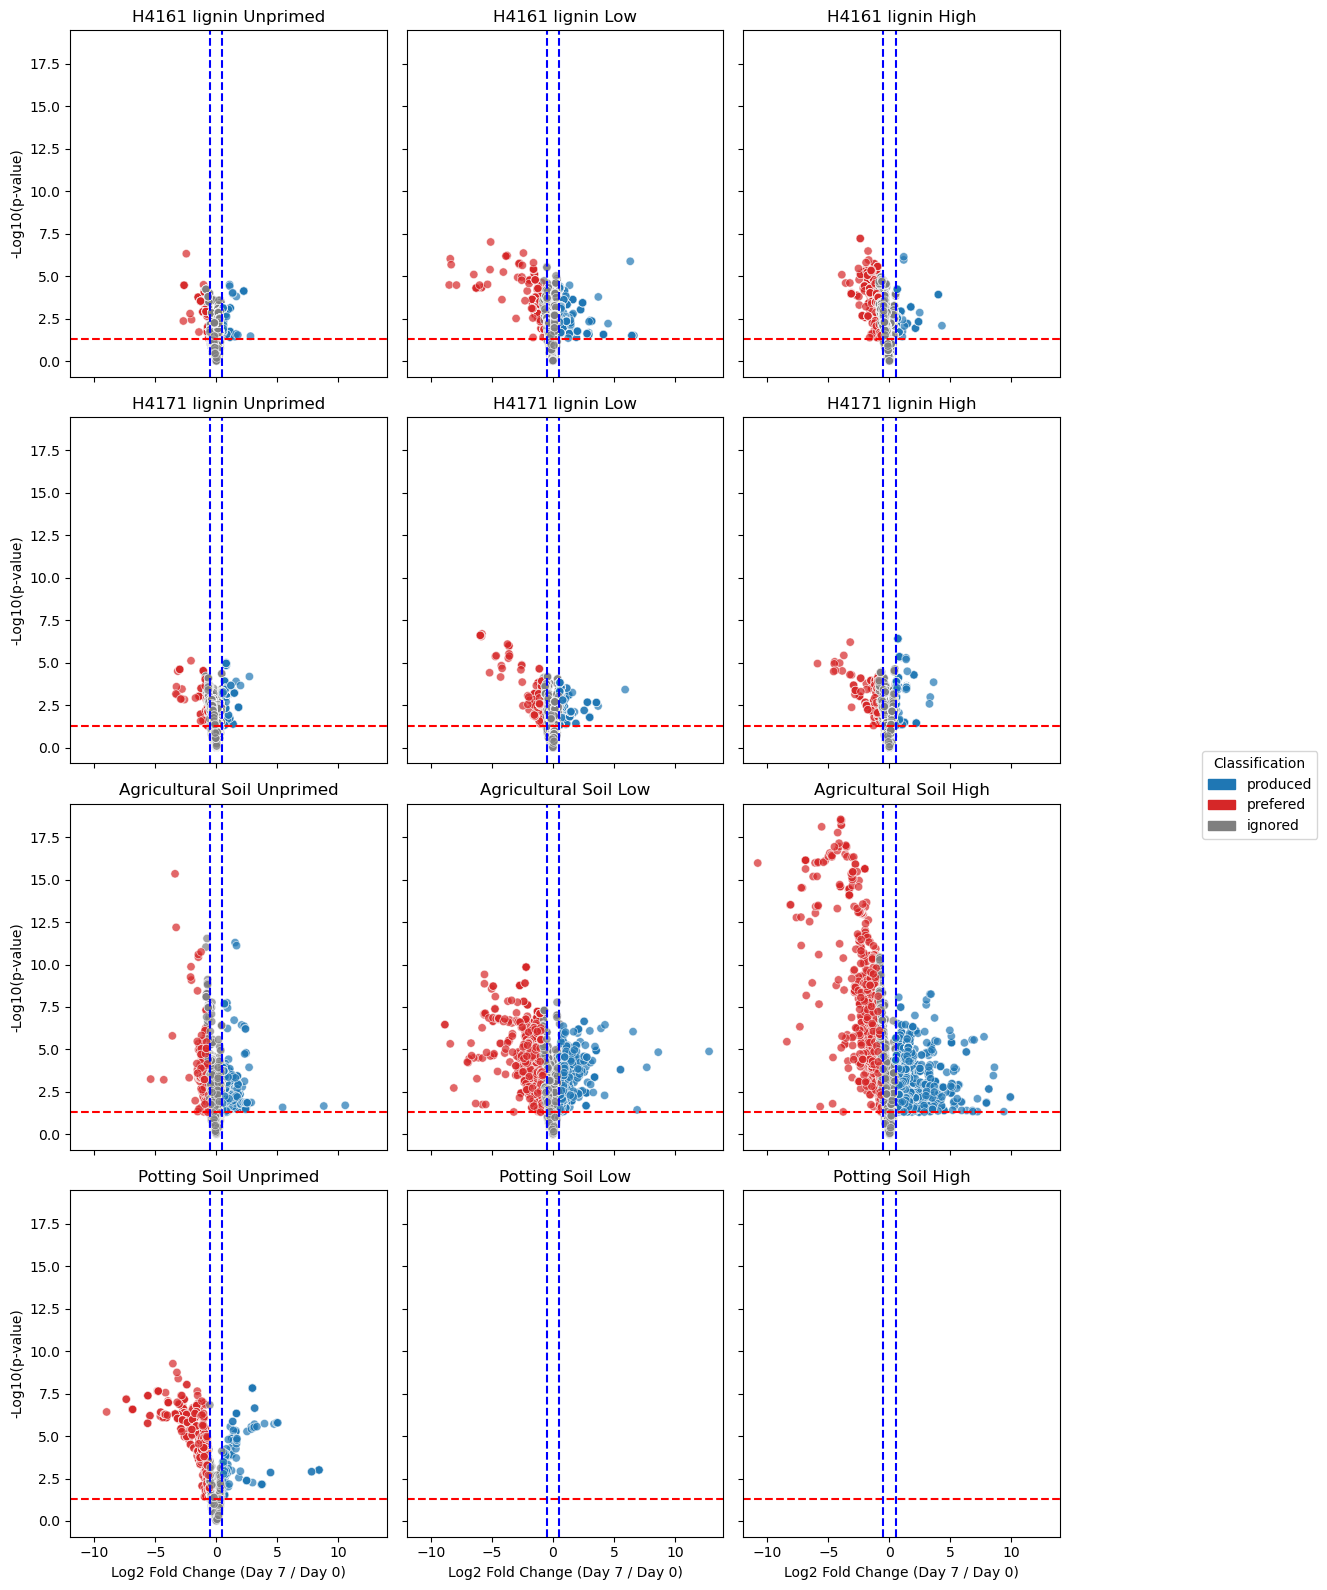

In [9]:


row_terms = final_df['soil_type'].unique()
num_rows = len(row_terms)
col_terms = ['Unprimed','Low','High']
num_cols = len(col_terms)

classification_colors = {
    'produced': '#1f77b4',  # Muted blue
    'prefered': '#d62728',  # Muted red
    'ignored': '#7f7f7f'    # Gray
}

fig,ax = plt.subplots(num_rows,num_cols, figsize=(4*num_cols,4*num_rows), sharex=True, sharey=True)
for i,row in enumerate(row_terms):
    for j,col in enumerate(col_terms):
        ax_ij = ax[i,j]
        idx = (final_df['soil_type']==row) & (final_df['priming']==col)
        plot_df = final_df[idx].copy()
        # idx = plot_df['p']<0.005
        # plot_df.loc[idx,'p'] = 0.005 + np.random.rand(sum(idx))*0.001
        # idx = plot_df['fc']>5
        # plot_df.loc[idx,'fc'] = 5 + np.random.rand(sum(idx))
        # idx = plot_df['fc']<-5
        # plot_df.loc[idx,'fc'] = -5 - np.random.rand(sum(idx))
        sns.scatterplot(data=plot_df, x='fc', y=-np.log10(plot_df['p']), 
                        hue='classification', 
                        palette=classification_colors, 
                        ax=ax_ij, alpha=0.7,legend=False)

        ax_ij.axhline(-np.log10(0.05), color='red', linestyle='--')
        ax_ij.axvline(0.5, color='blue', linestyle='--')
        ax_ij.axvline(-0.5, color='blue', linestyle='--')
        ax_ij.set_title(f'{row} {col}')
        if i == num_rows-1:
            ax_ij.set_xlabel('Log2 Fold Change (Day 7 / Day 0)')
        else:
            ax_ij.set_xlabel('')
        if j == 0:
            ax_ij.set_ylabel('-Log10(p-value)')
        else:
            ax_ij.set_ylabel('')


handles = [mpatches.Patch(color=color, label=label) for label, color in classification_colors.items()]

# Place the legend outside the plot area
fig.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), title='Classification')

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.9, 1])

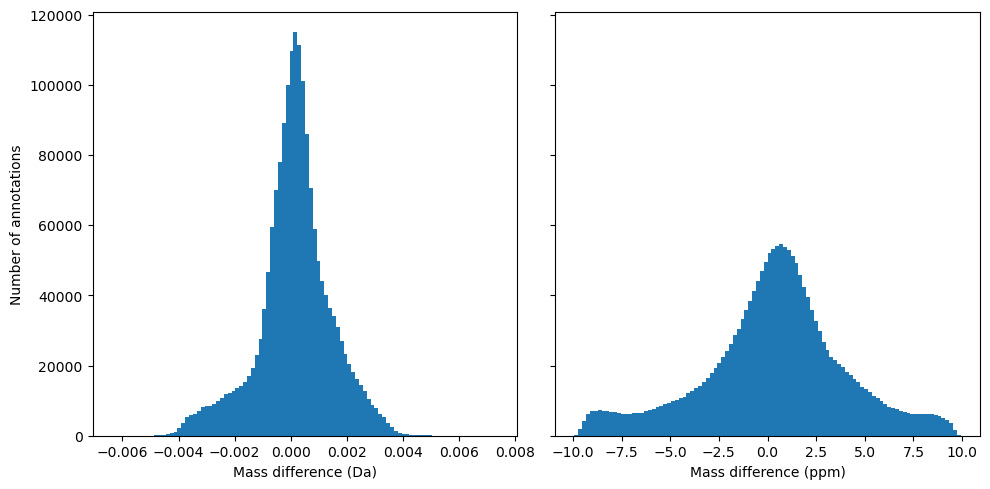

In [10]:
temp = pd.merge(ms1_df,node_data, on='original_index', how='left')
fig,ax = plt.subplots(1,2,figsize=(10,5),sharey=True)
mz_diff = temp['precursor_mz'] - temp['mz_centroid']
ax[0].hist(mz_diff,bins=100)
ax[0].set_xlabel('Mass difference (Da)')
ax[0].set_ylabel('Number of annotations')
mz_diff_ppm = mz_diff / temp['precursor_mz'] * 1e6
ax[1].hist(mz_diff_ppm,bins=100)
ax[1].set_xlabel('Mass difference (ppm)')
plt.tight_layout()


In [11]:
# merge in ms2 evidence
cols = ['original_index', 'has_ms2_evidence', 'project', 
       'priming', 'soil_type']
temp = ms1_df[cols].copy()
temp.sort_values(by=['has_ms2_evidence'], ascending=False, inplace=True)
merge_cols = ['original_index', 'project','priming','soil_type']
temp = temp.drop_duplicates(subset=merge_cols, keep='first')
final_df = pd.merge(final_df, temp, on=merge_cols, how='left')

In [12]:
final_df

,original_index,t,p,fc,tost,mean_treatment,mean_control,treatment_vals,control_vals,project,priming,soil_type,classification,has_ms2_evidence
0,14,-3.760906,1.975937e-02,-1.199437,6.664188e-01,1.788609e+07,4.107540e+07,"[16641790.149902344, 29106707.510986328, 79097...","[41809396.44390869, 41110302.28649902, 4030650...",LigDiv6,High,H4161 lignin,prefered,False
1,180,-2.272015,8.553710e-02,-0.208286,3.241153e-10,1.122272e+07,1.296577e+07,"[10604532.394042969, 12390641.122070312, 10672...","[13086437.820922852, 13760163.812133789, 12050...",LigDiv6,High,H4161 lignin,ignored,True
2,1043,0.599581,5.810943e-01,0.071798,6.612894e-08,2.729655e+08,2.597134e+08,"[248149827.51293945, 273791946.76782227, 29695...","[265831229.03735352, 227646395.23608398, 28566...",LigDiv6,High,H4161 lignin,ignored,True
3,3049,1.040470,3.568758e-01,0.148111,8.120127e-05,3.443599e+07,3.107613e+07,"[36690898.30505371, 28413333.48083496, 3820374...","[29790083.520385742, 33224444.62084961, 302138...",LigDiv6,High,H4161 lignin,ignored,False
4,3297,-8.855183,8.980726e-04,-1.068723,6.530680e-01,1.416847e+07,2.971944e+07,"[15523434.358032227, 16154113.364807129, 10827...","[30425974.073486328, 30005330.872924805, 28727...",LigDiv6,High,H4161 lignin,prefered,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99100,4717469,-2.251144,4.096547e-02,-0.194824,1.375870e-11,5.051898e+07,5.782326e+07,"[47238705.916015625, 61063009.88330078, 471377...","[59788873.544433594, 63764903.720703125, 49820...",WAVEstab,Unprimed,Potting Soil,ignored,True
99101,4718079,1.703129,1.106307e-01,0.367348,1.086936e-01,1.289276e+07,9.994542e+06,"[9460620.188476562, 14747361.655273438, 100784...","[6511772.777832031, 12618540.015136719, 743460...",WAVEstab,Unprimed,Potting Soil,None,True
99102,4718562,0.245378,8.097239e-01,0.051728,9.182719e-04,1.883980e+07,1.817626e+07,"[13103210.166015625, 23231704.51953125, 141455...","[12255199.51977539, 22842773.427490234, 142100...",WAVEstab,Unprimed,Potting Soil,ignored,True
99103,4719021,0.736166,4.737847e-01,0.182793,2.336292e-02,1.320883e+07,1.163692e+07,"[8644402.634765625, 16753103.798828125, 936344...","[6256028.275390625, 14683783.301757812, 830910...",WAVEstab,Unprimed,Potting Soil,ignored,True


In [13]:
final_df.to_csv('training data for stability model 20251024.csv', index=False)

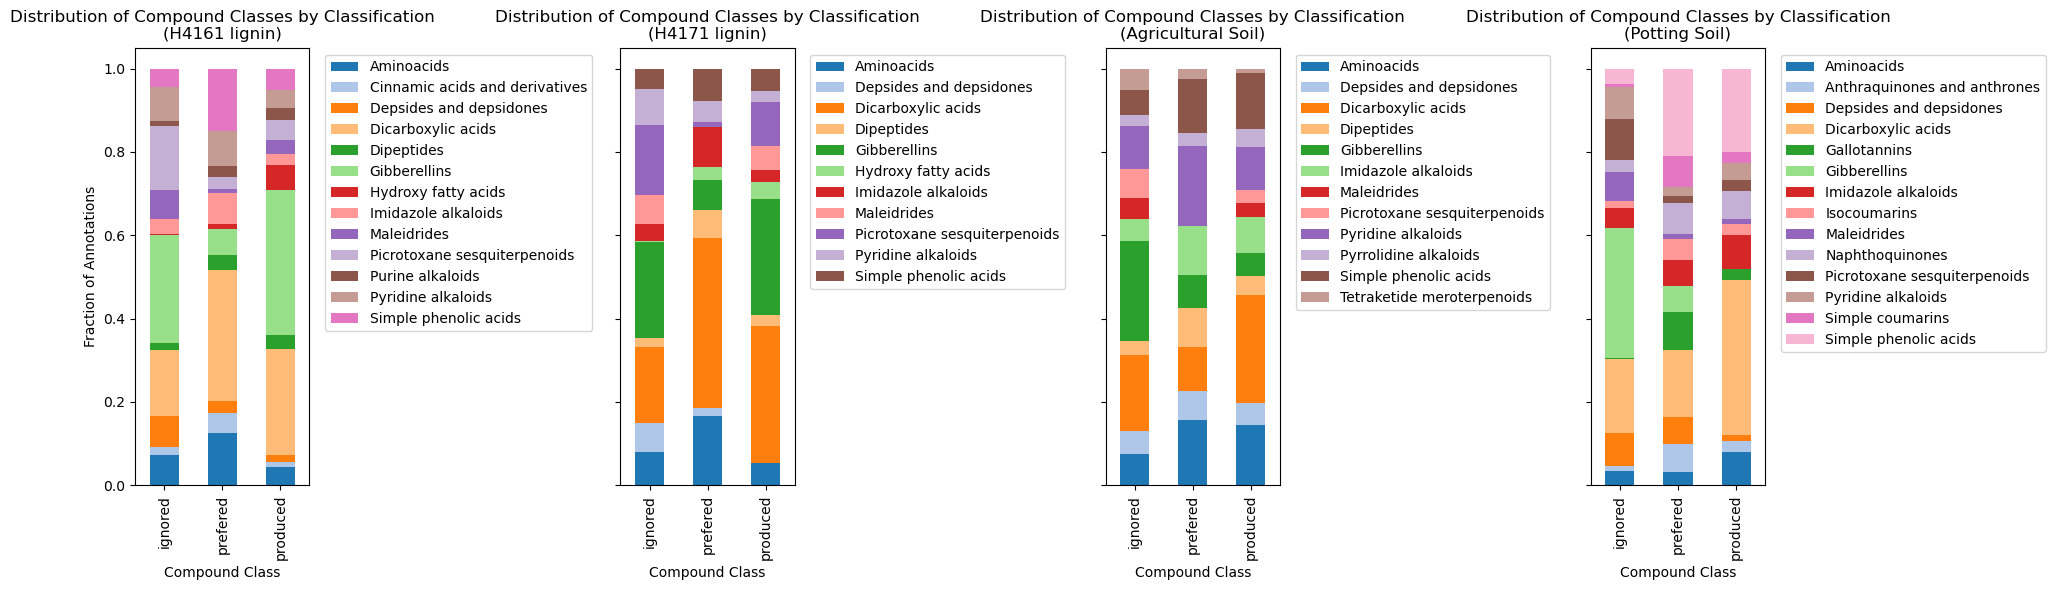

In [14]:
fig,all_axes = plt.subplots(figsize=(20,6),nrows=1,ncols=len(final_df['soil_type'].unique()), sharey=True)
counter = 0
class_term = 'NPC#class'
counter = 0
for soil_type in final_df['soil_type'].unique():
    ax = all_axes[counter]
    # make a stacked bar chart of the compound classes for each classification

    idx1 = final_df['classification'].notna()
    idx2 = final_df['soil_type'] == soil_type
    idx = idx1 & idx2
    classified_indices = final_df[idx].groupby('classification')['original_index'].unique().to_dict()
    out = []
    for key, value in classified_indices.items():
        idx = node_data['original_index'].isin(value)
        temp = node_data.loc[idx,class_term].value_counts()
        temp = temp.to_frame().reset_index().rename(columns={'index':'class','NPC#class':'count'})
        temp['classification'] = key
        temp['total'] = temp['count'].sum()
        temp['fraction'] = temp['count']/temp['total']
        out.append(temp)
    class_df = pd.concat(out, ignore_index=True)
    class_df = class_df.pivot(index='classification', columns='class', values='fraction')
    class_df.fillna(0,inplace=True)
    cols = class_df.columns[class_df.sum(axis=0)>0.05]
    class_df = class_df[cols]
    # sum each row to one
    class_df = class_df.div(class_df.sum(axis=1), axis=0)

    class_df.plot(kind='bar', stacked=True, ax=ax, color=sns.color_palette("tab20", n_colors=len(class_df.columns)))
    ax.set_ylabel('Fraction of Annotations')
    ax.set_xlabel('Compound Class')
    ax.set_title(f'Distribution of Compound Classes by Classification\n({soil_type})')
    # plt.xticks(rotation=45, ha='right')
    # move legend outside of plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    counter = counter + 1
plt.tight_layout()
plt.show()
